In [ ]:
# !pip install tensorflow_text
import tensorflow as tf
import tensorflow_text as tf_text
import re 
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import typing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
with open('/content/movie_lines.txt', 'r', encoding='cp1252') as movie_lines:
    lines = movie_lines.read().split('\n')
    
movie_line_dict = {}
for line in lines:
    text = line.split(' +++$+++ ')[-1]
    index = line.split(' +++$+++ ')[0]

    movie_line_dict[index] = text
        

with open('/content/movie_conversations.txt', 'r', encoding='cp1252') as movie_conversation:
    lines = movie_conversation.read().split('\n')
movie_conversation_list = [line.split(' +++$+++ ')[-1][1:-1].replace("'", '').split(', ') for line in lines]

In [ ]:
inp, targ  = [], []

for conv in movie_conversation_list:
    for line in range(len(conv)-1): 
        inp.append(movie_line_dict[conv[line]])
        targ.append(movie_line_dict[conv[line+1]])

In [ ]:
i = randint(0, len(inp))
print(f'Input_example: {inp[i]}')
print(f'Target example: {targ[i]}')

Input_example: Oh, sure.  Here, this can be mommy.
Target example: Do you like to be with your mommy?


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
len_seq_enc = [len(seq) for seq in inp]
len_seq_dec = [len(seq) for seq in targ]

for percentile in [30, 40, 80, 90]:
    print('{} percentile of encoder length sequances = {}'.
          format(percentile, np.percentile(len_seq_enc, percentile)))
    print('{} percentile of decoder length sequances = {}'.
          format(percentile, np.percentile(len_seq_dec, percentile)), end = '\n\n')
    
inp_trimmed, targ_trimmed = [], []

MIN_SEQ_LEN = 20
MAX_SEQ_LEN = 120

for i in range(len(inp)):
    if (len(inp[i]) >= MIN_SEQ_LEN and len(inp[i]) <= MAX_SEQ_LEN)\
    and (len(targ[i]) >= MIN_SEQ_LEN and len(targ[i]) <= MAX_SEQ_LEN):
        inp_trimmed.append(inp[i])
        targ_trimmed.append(targ[i])


print(f'sample shape Input = {len(inp_trimmed)}')
print(f'sample shape Tragte = {len(targ_trimmed)}')


30 percentile of encoder length sequances = 21.0
30 percentile of decoder length sequances = 21.0

40 percentile of encoder length sequances = 27.0
40 percentile of decoder length sequances = 28.0

80 percentile of encoder length sequances = 78.0
80 percentile of decoder length sequances = 81.0

90 percentile of encoder length sequances = 117.0
90 percentile of decoder length sequances = 122.0

sample shape Input = 89803
sample shape Tragte = 89803


In [ ]:
num_samples = 30000

result_inp = inp_trimmed[:num_samples]
result_targ = targ_trimmed[:num_samples]

In [ ]:
i = randint(0, len(result_inp))
print(f'Input example: {result_inp[i]}')
print(f'Target example: {result_targ[i]}')

Input example: "Thunder Road," Bruce Springsteen, from Born to Run. "Smells Like Teen Spirit," Nirvana, Nevermind.
Target example: Oh no, Rob, that's not obvious enough. Not at all.  Dick, did you hear that?


In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((result_inp, result_targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
i = randint(0, len(inp))
example_text = tf.constant(inp[i])

print(example_text.numpy())

b"Well, even if I'm not the wolfman, I am crazy enough to do something like that. I mean, here I sit in Leicester Square talking to a corpse. I'm glad to see you, Jack."


In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Vanessa. Shit, you better get out of here.'
 b'Promise me you will never leave me.' b'What can I do about it?'
 b'It was very silly.... I would be ashamed to wear it here.'
 b'I lived there for about nine months.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Why? What the big deal?' b'I cannot promise you that.'
 b"You can't do jack shit... unless you learn your evil powers."
 b'As beautiful as that? What else? Come, tell me.'
 b'You lived in Japan, when?'], shape=(5,), dtype=string)


In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Well, even if I'm not the wolfman, I am crazy enough to do something like that. I mean, here I sit in Leicester Square talking to a corpse. I'm glad to see you, Jack.
[START] well ,  even if im not the wolfman ,  i am crazy enough to do something like that .  i mean ,  here i sit in leicester square talking to a corpse .  im glad to see you ,  jack . [END]


In [ ]:
MAX_VOCAB_SIZE = 3000

text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=MAX_VOCAB_SIZE)

In [ ]:
text_processor.adapt(result_inp)

text_processor.get_vocabulary()[1000:1007]

['taste', 'strong', 'stick', 'station', 'single', 'ring', 'quiet']

In [ ]:
example_tokens = text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   3,    8,  582,   18,   29,  219,   20, 1792,    2, 1792],
       [   3,   75,    5,   47,   22,    1,  358,   17, 1148,    2],
       [   3,    9,  177,   38, 1285,   14,   20,   28,    1,  567]])>

In [ ]:
input_vocab = np.array(text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] i drive and my name is larry . larry from the states . [END]                                             '

Text(0.5, 1.0, 'Mask')

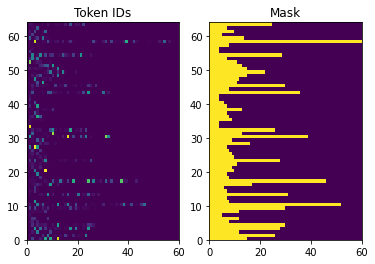

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
EMB_DIM = 256
UNITS = 512

In [ ]:
class DecoderInput(typing.NamedTuple):
    new_tokens: typing.Any
    enc_output: typing.Any
    mask: typing.Any

class DecoderOutput(typing.NamedTuple):
    logits: typing.Any
    attention_weights: typing.Any


class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               EMB_DIM)


    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):

    vectors = self.embedding(tokens)

    output, state = self.gru(vectors, initial_state=state)

    return output, state

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()

    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):

    w1_query = self.W1(query)

    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    return context_vector, attention_weights

class Decoder(tf.keras.layers.Layer):

  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.attention = BahdanauAttention(self.dec_units)

    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self,inputs: DecoderInput,state=None) -> typing.Tuple[DecoderOutput, tf.Tensor]:

    vectors = self.embedding(inputs.new_tokens)

    rnn_output, state = self.gru(vectors, initial_state=state)

    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)

    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    attention_vector = self.Wc(context_and_rnn_output)

    logits = self.fc(attention_vector)

    return DecoderOutput(logits, attention_weights), state



In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):

    loss = self.loss(y_true, y_pred)
    
    mask = tf.cast(y_true != 0, tf.float32)

    loss *= mask
    
    return tf.reduce_sum(loss)

In [ ]:
class TrainChatBot(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               text_processor,
               use_tf_function=True):
    super().__init__()

    encoder = Encoder(text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.text_processor = text_processor
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

  def _preprocess(self, input_text, target_text):


    input_tokens = self.text_processor(input_text)
    target_tokens = self.text_processor(target_text)

    input_mask = (input_tokens != 0)

    target_mask = (target_tokens != 0)

    return input_tokens, input_mask, target_tokens, target_mask

  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:

      enc_output, enc_state = self.encoder(input_tokens)

      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in tf.range(max_target_length-1):

        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    return {'batch_loss': average_loss}

  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [ ]:
ChatBot = TrainChatBot(
    EMB_DIM, UNITS,
    text_processor=text_processor,
    use_tf_function=True)

ChatBot.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
ChatBot.fit(dataset, epochs = 3, callbacks = [batch_loss])

Epoch 1/3
469/469 [==============================] - 1781s 4s/step - batch_loss: 4.5046
Epoch 2/3
469/469 [==============================] - 1786s 4s/step - batch_loss: 3.8957
Epoch 3/3
469/469 [==============================] - 1670s 4s/step - batch_loss: 3.6441


In [ ]:
class ChatBotAnsw(tf.Module):

  def __init__(self, encoder, decoder, text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.text_processor = text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True

    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

  def tokens_to_text(self, result_tokens):

    result_text_tokens = self.output_token_string_from_index(result_tokens)
    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    result_text = tf.strings.strip(result_text)
    return result_text

  def sample(self, logits, temperature):

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
    return new_tokens

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])  
  def get_answer(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
      dec_input = DecoderInput(new_tokens=new_tokens,
                              enc_output=enc_output,
                              mask=(input_tokens!=0))

      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention.append(dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      done = done | (new_tokens == self.end_token)

      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      result_tokens.append(new_tokens)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return { 'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}


  

In [ ]:
simple_input = tf.constant(result_inp[:5])
simple_target = tf.constant(result_targ[:5])




chatbotansw = ChatBotAnsw(
    encoder=ChatBot.encoder,
    decoder=ChatBot.decoder,
    text_processor=text_processor,
)

ans = chatbotansw.get_answer(input_text = simple_input, )

for i in range(simple_input.shape[0]):
  print(f'\nInput text: {simple_input[i]}')
  print(f"ChatBot`s answer text: {ans['text'][i]}")
  print(f"Tareget text : {simple_target[i]}",
        end = '\n\n=====================================================================\n\n')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Input text: b"Well, I thought we'd start with pronunciation, if that's okay with you."
ChatBot`s answer text: b'what did you name ?'
Tareget text : b'Not the hacking and gagging and spitting part.  Please.'



Input text: b'Not the hacking and gagging and spitting part.  Please.'
ChatBot`s answer text: b'youll call me wrong , there . wheres in here ?'
Tareget text : b"Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"



Input text: b'Gosh, if only we could find Kat a boyfriend...'
ChatBot`s answer text: b'didnt go across best . thats why you mind now ?'
Tareget text : b'Let me see what I can do.'



Input text: b"C'esc ma tete. This is my head"
ChatBot`s answer text: b'nothing away will make later any choice , you know so tell you , i called . see im not going to promise .'
Tareget text : b"Right.  See?  You're ready for the quiz."



Input text: b'How is our little Find the Wench A Date plan progressing?'
ChatBot`s answer text: b'you should follow me , would 

In [ ]:
ChatBot.save_weights('/content/drive/MyDrive/ChatBot with attention/', save_format = 'tf')